## Import Libraries

In [1]:
!pip install torch-geometric

import os
import numpy as np
import pyarrow as pa
import pandas as pd
import pyarrow.parquet as pq
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.spatial.distance import cdist
from tqdm import tqdm
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00a 0:00:01


## Disable Warnings

In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

## Load Data

In [3]:
def read_file(path):
  chunk_size = 25

# Create a Parquet file reader object
  parquet_file = pq.ParquetFile(path)

# Determine the total number of rows in the file
  total_rows = parquet_file.metadata.num_rows

# Loop over the file in chunks
  data = []
  for i in range(0, total_rows, chunk_size):
    # Read a chunk of rows from the file
      chunk = (parquet_file.read_row_group(i))
      dm = (chunk.to_pandas())
      data.append(dm)

# Concatenate all the DataFrames into a single DataFrame
  df = pd.concat(data, ignore_index=True)
  print(parquet_file.read_row_group(0).to_pandas())
  return df

In [4]:
df1 = read_file('/kaggle/input/common-task-2-dataset/Task - 2 Data (Parquet)/jet0_run0.test.snappy.parquet')
df2 = read_file('/kaggle/input/common-task-2-dataset/Task - 2 Data (Parquet)/jet0_run1.test.snappy.parquet')
df3 = read_file('/kaggle/input/common-task-2-dataset/Task - 2 Data (Parquet)/jet0_run2.test.snappy.parquet')

                                              X_jets          pt         m0  \
0  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  112.411095  21.098248   

     y  
0  0.0  
                                              X_jets          pt         m0  \
0  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  147.686737  32.114449   

     y  
0  0.0  
                                              X_jets          pt         m0  \
0  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  107.854118  18.723455   

     y  
0  0.0  


In [5]:
def construct_image_dataset(df):
    # Get the total number of samples
    num_samples = len(df)

    # Initialize empty arrays for X and y
    X = np.empty((num_samples, 3, 125, 125), dtype=np.float32)
    y = np.empty(num_samples, dtype=int)

    # Iterate through the DataFrame and fill X and y
    for i, row in df.iterrows():
        # Stack the three channels of X_jets and transpose them to match the desired shape
        X[i] = np.transpose(np.dstack((np.stack(row['X_jets'][0]), np.stack(row['X_jets'][1]), np.stack(row['X_jets'][2]))), (2, 0, 1))
        # Assign the label to y
        y[i] = row['y']

    # Rearrange the dimensions of X to match the TensorFlow format (samples, height, width, channels)
    X = np.transpose(X, (0, 2, 3, 1))

    return X, y

In [6]:
# Assuming 'df' is the pandas DataFrame
X1, y1 = construct_image_dataset(df1)
X2, y2 = construct_image_dataset(df2)
X3, y3 = construct_image_dataset(df3)

In [7]:
# Save X1 array to binary file 'X1.npy'
with open('X1.npy', 'wb') as f:
    np.save(f, X1)

# Save y1 array to binary file 'y1.npy'
with open('y1.npy', 'wb') as f:
    np.save(f, y1)

# Save X2 array to binary file 'X2.npy'
with open('X2.npy', 'wb') as f:
    np.save(f, X2)

# Save y2 array to binary file 'y2.npy'
with open('y2.npy', 'wb') as f:
    np.save(f, y2)

# Save X3 array to binary file 'X3.npy'
with open('X3.npy', 'wb') as f:
    np.save(f, X3)

# Save y3 array to binary file 'y3.npy'
with open('y3.npy', 'wb') as f:
    np.save(f, y3)

In [8]:
x1 = np.load('X1.npy')
x2 = np.load('X2.npy')
x3 = np.load('X3.npy')

y1 = np.load('y1.npy')
y2 = np.load('y2.npy')
y3 = np.load('y3.npy')

In [9]:
# Combine x arrays along the first axis (axis=0)
x = np.concatenate((x1, x2, x3), axis=0)

# Combine y arrays along the first axis (axis=0)
y = np.concatenate((y1, y2, y3), axis=0)

# Save the combined X array to a binary file named 'X.npy'
with open('x.npy', 'wb') as f:
    np.save(f, x)

# Save the combined y array to a binary file named 'y.npy'
with open('y.npy', 'wb') as f:
    np.save(f, y)

In [10]:
# Load the dataset
X = np.load("x.npy")
y = np.load("y.npy")

# Convert the numpy arrays to PyTorch tensors
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.int)

In [11]:
def linear_kernel(distance_matrix, gamma=None):
    if gamma is None:
        gamma = 1.0 / distance_matrix.shape[1]
    return gamma * np.dot(distance_matrix, gamma)

def construct_graph_using_linear_kernel(image, label):
    height, width, channels = image.shape
    nodes = []
    positions = []

    # Iterate over the 5x5 crops and extract features
    for i in range(0, height, 5):
        for j in range(0, width, 5):
            crop = image[i:i+5, j:j+5]
            feature = crop.reshape(-1)
            nodes.append(feature)
            positions.append((i, j))

    nodes = torch.stack(nodes)
    positions = np.array(positions)

    # Compute edge_index and edge_attr using Linear Kernel
    distance_matrix = cdist(positions, positions)
    linear_values = linear_kernel(distance_matrix)
    edges = np.where(linear_values > 0.8)  # Adjust threshold as needed
    edge_index = torch.tensor(np.vstack(edges), dtype=torch.long)
    edge_attr = torch.tensor(linear_values[edges], dtype=torch.float)

    # Create the PyTorch Geometric Data object
    data = Data(x=nodes, edge_index=edge_index, edge_attr=edge_attr, y=torch.tensor([label], dtype=torch.long))
    return data

In [12]:
filename = "pyg_data_list.pkl"
if os.path.exists(filename):
    print(f"{filename} exists in the current directory.")
    with open("pyg_data_list.pkl", "rb") as file:
        pyg_data_list = pickle.load(file)
else:
    print(f"{filename} does not exist in the current directory.")
    # Create PyTorch Geometric Data objects for each image
    pyg_data_list = [construct_graph_using_linear_kernel(X[i], y[i]) for i in tqdm(range(X.shape[0]), desc="Creating Data Objects")]

pyg_data_list.pkl does not exist in the current directory.


Creating Data Objects: 100%|██████████| 5573/5573 [01:17<00:00, 71.50it/s]


## Splitting Data into train_dataset and test_dataset

In [13]:
# Set up the train and test datasets
train_dataset = pyg_data_list[:int(len(pyg_data_list) * 0.75)]
test_dataset = pyg_data_list[int(len(pyg_data_list) * 0.75):]

# Set up the data loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Building Graph Attention Networks (GAT) Model

In [14]:
class GATModel(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(num_node_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc(x)
        return x

## Set up the GAT model, loss function, and optimizer

In [15]:
num_node_features = train_dataset[0].x.shape[1]
hidden_channels = 64
num_classes = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GATModel(num_node_features, hidden_channels, num_classes).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Define training and evaluation functions

In [16]:
def train():
    model.train()
    total_loss = 0
    for data in tqdm(train_loader, desc="Training"):
        data = data.to(device)
        optimizer.zero_grad() # To Clear gradients
        out = model(data) # Perform a single forward pass
        loss = criterion(out, data.y) # Compute the loss
        loss.backward() # Deriving gradients
        optimizer.step() # Updating parameters
        total_loss += loss.item()
    return total_loss / len(train_loader)

def test(loader):
    model.eval()
    correct = 0
    y_true = []
    y_probs = []

    for data in tqdm(loader, desc="Testing"):
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
        probs = F.softmax(out, dim=-1)
        pred = out.argmax(dim=-1)

        y_true.extend(data.y.tolist())
        y_probs.extend(probs[:, 1].tolist())

        correct += int((pred == data.y).sum())

    false_pr, true_pr, _ = roc_curve(y_true, y_probs)
    roc_auc = roc_auc_score(y_true, y_probs)
    accuracy = correct / len(loader.dataset)

    return accuracy, false_pr, true_pr, roc_auc

## Function to plot ROC curve

In [17]:
def plot_roc_curve(false_pr, true_pr, roc_auc, title="ROC curve"):
    plt.figure()
    plt.plot(false_pr, true_pr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color="blue", lw=2, linestyle="-.")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig("gat-roc-curve.png")
    plt.show()

## Train and Evaluate the model

Testing: 100%|██████████| 44/44 [00:00<00:00, 130.57it/s]


Epoch: 1, Loss: 0.6926, Train (Accuracy): 0.5085, Train (ROC-AUC): 0.5845, Test (Accuracy): 0.5100, Test (ROC-AUC): 0.5720


Testing: 100%|██████████| 44/44 [00:00<00:00, 130.74it/s]


Epoch: 2, Loss: 0.6926, Train (Accuracy): 0.5085, Train (ROC-AUC): 0.6549, Test (Accuracy): 0.5108, Test (ROC-AUC): 0.6336


Testing: 100%|██████████| 44/44 [00:00<00:00, 103.56it/s]


Epoch: 3, Loss: 0.6902, Train (Accuracy): 0.6068, Train (ROC-AUC): 0.6720, Test (Accuracy): 0.6011, Test (ROC-AUC): 0.6506


Testing: 100%|██████████| 44/44 [00:00<00:00, 131.92it/s]


Epoch: 4, Loss: 0.6806, Train (Accuracy): 0.6420, Train (ROC-AUC): 0.6927, Test (Accuracy): 0.6105, Test (ROC-AUC): 0.6679


Testing: 100%|██████████| 44/44 [00:00<00:00, 134.43it/s]


Epoch: 5, Loss: 0.6653, Train (Accuracy): 0.6557, Train (ROC-AUC): 0.7077, Test (Accuracy): 0.6212, Test (ROC-AUC): 0.6788


Testing: 100%|██████████| 44/44 [00:00<00:00, 132.44it/s]


Epoch: 6, Loss: 0.6488, Train (Accuracy): 0.6633, Train (ROC-AUC): 0.7200, Test (Accuracy): 0.6313, Test (ROC-AUC): 0.6891


Testing: 100%|██████████| 44/44 [00:00<00:00, 137.00it/s]


Epoch: 7, Loss: 0.6354, Train (Accuracy): 0.6700, Train (ROC-AUC): 0.7311, Test (Accuracy): 0.6277, Test (ROC-AUC): 0.6970


Testing: 100%|██████████| 44/44 [00:00<00:00, 131.61it/s]


Epoch: 8, Loss: 0.6280, Train (Accuracy): 0.6791, Train (ROC-AUC): 0.7384, Test (Accuracy): 0.6435, Test (ROC-AUC): 0.7031


Testing: 100%|██████████| 44/44 [00:00<00:00, 137.05it/s]


Epoch: 9, Loss: 0.6210, Train (Accuracy): 0.6815, Train (ROC-AUC): 0.7455, Test (Accuracy): 0.6428, Test (ROC-AUC): 0.7098


Testing: 100%|██████████| 44/44 [00:00<00:00, 136.48it/s]


Epoch: 10, Loss: 0.6179, Train (Accuracy): 0.6927, Train (ROC-AUC): 0.7506, Test (Accuracy): 0.6506, Test (ROC-AUC): 0.7149


Testing: 100%|██████████| 44/44 [00:00<00:00, 133.15it/s]


Epoch: 11, Loss: 0.6113, Train (Accuracy): 0.6961, Train (ROC-AUC): 0.7563, Test (Accuracy): 0.6593, Test (ROC-AUC): 0.7195


Testing: 100%|██████████| 44/44 [00:00<00:00, 132.48it/s]


Epoch: 12, Loss: 0.6107, Train (Accuracy): 0.7021, Train (ROC-AUC): 0.7621, Test (Accuracy): 0.6571, Test (ROC-AUC): 0.7215


Testing: 100%|██████████| 44/44 [00:00<00:00, 134.31it/s]


Epoch: 13, Loss: 0.6048, Train (Accuracy): 0.7045, Train (ROC-AUC): 0.7667, Test (Accuracy): 0.6600, Test (ROC-AUC): 0.7239


Testing: 100%|██████████| 44/44 [00:00<00:00, 132.67it/s]


Epoch: 14, Loss: 0.5974, Train (Accuracy): 0.7078, Train (ROC-AUC): 0.7711, Test (Accuracy): 0.6714, Test (ROC-AUC): 0.7275


Testing: 100%|██████████| 44/44 [00:00<00:00, 114.67it/s]


Epoch: 15, Loss: 0.5921, Train (Accuracy): 0.7109, Train (ROC-AUC): 0.7763, Test (Accuracy): 0.6650, Test (ROC-AUC): 0.7291


Testing: 100%|██████████| 44/44 [00:00<00:00, 134.08it/s]


Epoch: 16, Loss: 0.5902, Train (Accuracy): 0.7124, Train (ROC-AUC): 0.7809, Test (Accuracy): 0.6650, Test (ROC-AUC): 0.7317


Testing: 100%|██████████| 44/44 [00:00<00:00, 132.62it/s]


Epoch: 17, Loss: 0.5906, Train (Accuracy): 0.7200, Train (ROC-AUC): 0.7845, Test (Accuracy): 0.6679, Test (ROC-AUC): 0.7353


Testing: 100%|██████████| 44/44 [00:00<00:00, 126.99it/s]


Epoch: 18, Loss: 0.5823, Train (Accuracy): 0.7241, Train (ROC-AUC): 0.7863, Test (Accuracy): 0.6707, Test (ROC-AUC): 0.7371


Testing: 100%|██████████| 44/44 [00:00<00:00, 130.00it/s]


Epoch: 19, Loss: 0.5841, Train (Accuracy): 0.7291, Train (ROC-AUC): 0.7884, Test (Accuracy): 0.6693, Test (ROC-AUC): 0.7364


Testing: 100%|██████████| 44/44 [00:00<00:00, 133.82it/s]


Epoch: 20, Loss: 0.5773, Train (Accuracy): 0.7246, Train (ROC-AUC): 0.7937, Test (Accuracy): 0.6758, Test (ROC-AUC): 0.7371


Testing: 100%|██████████| 44/44 [00:00<00:00, 135.33it/s]


Epoch: 21, Loss: 0.5744, Train (Accuracy): 0.7255, Train (ROC-AUC): 0.7969, Test (Accuracy): 0.6822, Test (ROC-AUC): 0.7389


Testing: 100%|██████████| 44/44 [00:00<00:00, 132.22it/s]


Epoch: 22, Loss: 0.5695, Train (Accuracy): 0.7315, Train (ROC-AUC): 0.7969, Test (Accuracy): 0.6750, Test (ROC-AUC): 0.7392


Testing: 100%|██████████| 44/44 [00:00<00:00, 127.09it/s]


Epoch: 23, Loss: 0.5694, Train (Accuracy): 0.7306, Train (ROC-AUC): 0.7999, Test (Accuracy): 0.6793, Test (ROC-AUC): 0.7405


Testing: 100%|██████████| 44/44 [00:00<00:00, 138.69it/s]


Epoch: 24, Loss: 0.5691, Train (Accuracy): 0.7387, Train (ROC-AUC): 0.8035, Test (Accuracy): 0.6858, Test (ROC-AUC): 0.7414


Testing: 100%|██████████| 44/44 [00:00<00:00, 135.02it/s]


Epoch: 25, Loss: 0.5663, Train (Accuracy): 0.7413, Train (ROC-AUC): 0.8048, Test (Accuracy): 0.6707, Test (ROC-AUC): 0.7403


Testing: 100%|██████████| 44/44 [00:00<00:00, 126.75it/s]


Epoch: 26, Loss: 0.5631, Train (Accuracy): 0.7428, Train (ROC-AUC): 0.8088, Test (Accuracy): 0.6815, Test (ROC-AUC): 0.7417


Testing: 100%|██████████| 44/44 [00:00<00:00, 137.69it/s]


Epoch: 27, Loss: 0.5608, Train (Accuracy): 0.7452, Train (ROC-AUC): 0.8118, Test (Accuracy): 0.6758, Test (ROC-AUC): 0.7385


Testing: 100%|██████████| 44/44 [00:00<00:00, 135.30it/s]


Epoch: 28, Loss: 0.5567, Train (Accuracy): 0.7411, Train (ROC-AUC): 0.8150, Test (Accuracy): 0.6872, Test (ROC-AUC): 0.7402


Testing: 100%|██████████| 44/44 [00:00<00:00, 136.16it/s]


Epoch: 29, Loss: 0.5531, Train (Accuracy): 0.7504, Train (ROC-AUC): 0.8150, Test (Accuracy): 0.6765, Test (ROC-AUC): 0.7409


Testing: 100%|██████████| 44/44 [00:00<00:00, 134.42it/s]


Epoch: 30, Loss: 0.5497, Train (Accuracy): 0.7487, Train (ROC-AUC): 0.8165, Test (Accuracy): 0.6722, Test (ROC-AUC): 0.7407


Testing: 100%|██████████| 44/44 [00:00<00:00, 132.55it/s]


Epoch: 31, Loss: 0.5492, Train (Accuracy): 0.7499, Train (ROC-AUC): 0.8209, Test (Accuracy): 0.6786, Test (ROC-AUC): 0.7380


Testing: 100%|██████████| 44/44 [00:00<00:00, 135.24it/s]


Epoch: 32, Loss: 0.5428, Train (Accuracy): 0.7533, Train (ROC-AUC): 0.8224, Test (Accuracy): 0.6743, Test (ROC-AUC): 0.7415


Testing: 100%|██████████| 44/44 [00:00<00:00, 129.76it/s]


Epoch: 33, Loss: 0.5399, Train (Accuracy): 0.7514, Train (ROC-AUC): 0.8221, Test (Accuracy): 0.6765, Test (ROC-AUC): 0.7417


Testing: 100%|██████████| 44/44 [00:00<00:00, 134.30it/s]


Epoch: 34, Loss: 0.5399, Train (Accuracy): 0.7578, Train (ROC-AUC): 0.8250, Test (Accuracy): 0.6758, Test (ROC-AUC): 0.7410


Testing: 100%|██████████| 44/44 [00:00<00:00, 133.47it/s]


Epoch: 35, Loss: 0.5389, Train (Accuracy): 0.7598, Train (ROC-AUC): 0.8294, Test (Accuracy): 0.6722, Test (ROC-AUC): 0.7379


Testing: 100%|██████████| 44/44 [00:00<00:00, 130.71it/s]


Epoch: 36, Loss: 0.5331, Train (Accuracy): 0.7550, Train (ROC-AUC): 0.8289, Test (Accuracy): 0.6693, Test (ROC-AUC): 0.7390


Testing: 100%|██████████| 44/44 [00:00<00:00, 136.17it/s]


Epoch: 37, Loss: 0.5330, Train (Accuracy): 0.7614, Train (ROC-AUC): 0.8321, Test (Accuracy): 0.6779, Test (ROC-AUC): 0.7347


Testing: 100%|██████████| 44/44 [00:00<00:00, 134.43it/s]


Epoch: 38, Loss: 0.5291, Train (Accuracy): 0.7619, Train (ROC-AUC): 0.8364, Test (Accuracy): 0.6844, Test (ROC-AUC): 0.7365


Testing: 100%|██████████| 44/44 [00:00<00:00, 124.54it/s]


Epoch: 39, Loss: 0.5271, Train (Accuracy): 0.7583, Train (ROC-AUC): 0.8391, Test (Accuracy): 0.6693, Test (ROC-AUC): 0.7334


Testing: 100%|██████████| 44/44 [00:00<00:00, 133.19it/s]


Epoch: 40, Loss: 0.5237, Train (Accuracy): 0.7722, Train (ROC-AUC): 0.8396, Test (Accuracy): 0.6750, Test (ROC-AUC): 0.7365


Testing: 100%|██████████| 44/44 [00:00<00:00, 132.66it/s]


Epoch: 41, Loss: 0.5252, Train (Accuracy): 0.7636, Train (ROC-AUC): 0.8430, Test (Accuracy): 0.6700, Test (ROC-AUC): 0.7328


Testing: 100%|██████████| 44/44 [00:00<00:00, 133.47it/s]


Epoch: 42, Loss: 0.5217, Train (Accuracy): 0.7717, Train (ROC-AUC): 0.8436, Test (Accuracy): 0.6793, Test (ROC-AUC): 0.7351


Testing: 100%|██████████| 44/44 [00:00<00:00, 135.31it/s]


Epoch: 43, Loss: 0.5218, Train (Accuracy): 0.7698, Train (ROC-AUC): 0.8471, Test (Accuracy): 0.6693, Test (ROC-AUC): 0.7320


Testing: 100%|██████████| 44/44 [00:00<00:00, 138.35it/s]


Epoch: 44, Loss: 0.5151, Train (Accuracy): 0.7767, Train (ROC-AUC): 0.8465, Test (Accuracy): 0.6765, Test (ROC-AUC): 0.7327


Testing: 100%|██████████| 44/44 [00:00<00:00, 134.14it/s]


Epoch: 45, Loss: 0.5159, Train (Accuracy): 0.7741, Train (ROC-AUC): 0.8473, Test (Accuracy): 0.6793, Test (ROC-AUC): 0.7344


Testing: 100%|██████████| 44/44 [00:00<00:00, 128.70it/s]


Epoch: 46, Loss: 0.5098, Train (Accuracy): 0.7803, Train (ROC-AUC): 0.8501, Test (Accuracy): 0.6808, Test (ROC-AUC): 0.7349


Testing: 100%|██████████| 44/44 [00:00<00:00, 136.86it/s]


Epoch: 47, Loss: 0.5104, Train (Accuracy): 0.7827, Train (ROC-AUC): 0.8529, Test (Accuracy): 0.6743, Test (ROC-AUC): 0.7305


Testing: 100%|██████████| 44/44 [00:00<00:00, 132.09it/s]


Epoch: 48, Loss: 0.5049, Train (Accuracy): 0.7849, Train (ROC-AUC): 0.8541, Test (Accuracy): 0.6758, Test (ROC-AUC): 0.7293


Testing: 100%|██████████| 44/44 [00:00<00:00, 133.18it/s]


Epoch: 49, Loss: 0.5057, Train (Accuracy): 0.7861, Train (ROC-AUC): 0.8568, Test (Accuracy): 0.6758, Test (ROC-AUC): 0.7275


Testing: 100%|██████████| 44/44 [00:00<00:00, 135.99it/s]


Epoch: 50, Loss: 0.5025, Train (Accuracy): 0.7619, Train (ROC-AUC): 0.8513, Test (Accuracy): 0.6815, Test (ROC-AUC): 0.7372


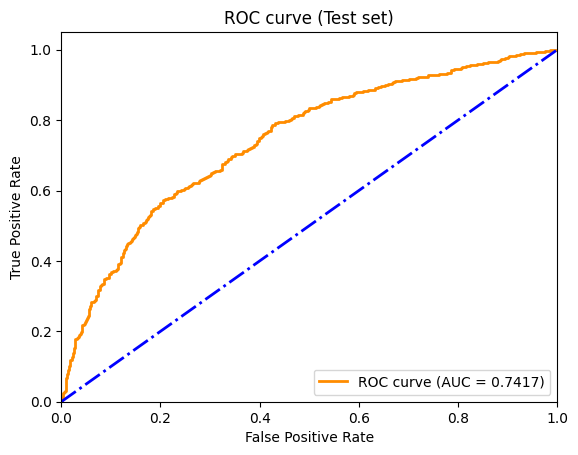

In [18]:
num_epochs = 50
max_auc = 0

for epoch in range(num_epochs):
    loss = train()
    train_acc, _, _, train_roc_auc = test(train_loader)
    test_acc, false_pr, true_pr, test_roc_auc = test(test_loader)
    print(f"Epoch: {epoch + 1}, Loss: {loss:.4f}, Train (Accuracy): {train_acc:.4f}, Train (ROC-AUC): {train_roc_auc:.4f}, Test (Accuracy): {test_acc:.4f}, Test (ROC-AUC): {test_roc_auc:.4f}")
    if test_roc_auc > max_auc:
        max_auc = test_roc_auc
        max_false_pr, max_true_pr, = false_pr, true_pr

plot_roc_curve(max_false_pr, max_true_pr, max_auc, title="ROC curve (Test set)")